# E-tivity 3: Clustering and Manifold Learning

Use this notebook to complete Tasks 1 and 2 in E-tivity3.

### Import Python Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold
from sklearn import cluster
from sklearn import preprocessing

In [4]:
df = pd.read_csv("loans_dataset_et3.csv")
"|".join(df.columns.values)

'ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History'

In [5]:
df.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,2483,2466.0,90,180,0
1,4917,0.0,130,360,0
2,4106,0.0,40,180,1
3,3859,3300.0,142,180,1
4,6417,0.0,157,180,1


In [33]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,5201.093373,1495.508795,140.882530,341.710843,0.978916
std,4584.815491,1982.742932,75.544237,61.651497,0.143882
min,645.000000,0.000000,17.000000,60.000000,0.000000
25%,2912.750000,0.000000,100.000000,360.000000,1.000000
50%,3858.500000,1211.500000,128.000000,360.000000,1.000000
75%,5818.250000,2250.000000,162.000000,360.000000,1.000000
max,39999.000000,20000.000000,600.000000,480.000000,1.000000


In [6]:
data = np.array(df.values, dtype=float)

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

In [25]:
data[0:5,:] #head numpy

array([[0.04670427, 0.1233    , 0.12521441, 0.28571429, 0.        ],
       [0.10855313, 0.        , 0.19382504, 0.71428571, 0.        ],
       [0.08794532, 0.        , 0.03945111, 0.28571429, 1.        ],
       [0.08166895, 0.165     , 0.21440823, 0.28571429, 1.        ],
       [0.1466687 , 0.        , 0.24013722, 0.28571429, 1.        ]])

In [10]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [ ]:
num_clust = 5

for k in range(2, num_clust+1):
    clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)
    data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

    f, axs = plt.subplots(1, 6, figsize=(20, 5))
    plt.subplot(1, 6, 1)
    XYcoord_mds = manifold.MDS(n_components=2).fit_transform(data_and_centers)
    clustering_scatterplot(points=XYcoord_mds[:-k,:],labels=clustered_data_sklearn.labels_,centers=XYcoord_mds[-k:,:],title='MDS: Number of Clusters {}'.format(k))
    
    #plt.subplot(1, 6, 2)
    #model = Isomap(n_components=2)
    #proj = model.fit_transform(data)
    #plt.scatter(XYcoord_mds[:-k,:], c=clustered_data_sklearn.labels, cmap=plt.cm.get_cmap('jet', 10))
    #plt.colorbar(ticks=range(10))
    #plt.clim(-0.5, 9.5);
    
    plt.subplot(1, 6, 4)
    XYcoord_mds = manifold.TSNE(n_components=2,perplexity=5).fit_transform(data_and_centers)
    clustering_scatterplot(points=XYcoord_mds[:-k,:],labels=clustered_data_sklearn.labels_,centers=XYcoord_mds[-k:,:],title='TSNE: Number of Clusters {}'.format(k))
    plt.subplot(1, 6, 5)
    XYcoord_mds = manifold.TSNE(n_components=2,perplexity=25).fit_transform(data_and_centers)
    clustering_scatterplot(points=XYcoord_mds[:-k,:],labels=clustered_data_sklearn.labels_,centers=XYcoord_mds[-k:,:],title='TSNE: Number of Clusters {}'.format(k))
    plt.subplot(1, 6, 6)
    XYcoord_mds = manifold.TSNE(n_components=2,perplexity=50).fit_transform(data_and_centers)
    clustering_scatterplot(points=XYcoord_mds[:-k,:],labels=clustered_data_sklearn.labels_,centers=XYcoord_mds[-k:,:],title='TSNE: Number of Clusters {}'.format(k))
    plt.show()

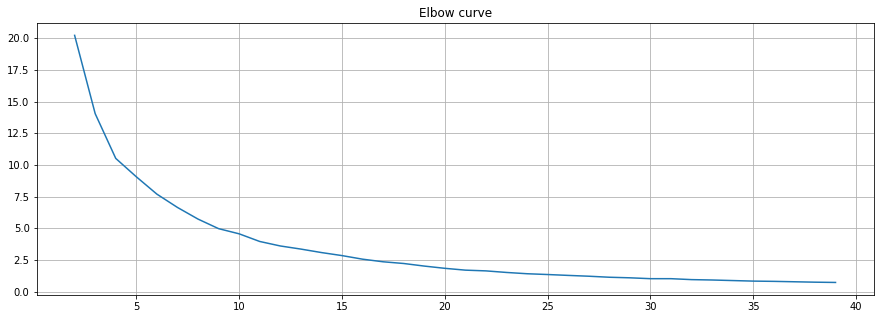

In [22]:
from sklearn.cluster import KMeans
num_clust = 40
distorsions = []
for k in range(2, num_clust):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, num_clust), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()